## Seismic bumps
### Introducción

El dataset elegido se corresponde con un conjunto de datos relacionados con el sector minero, concretamente fueron obtenidos en una mina de carbón de Polonia. El dataser describe, por cada muestra, una situación en la que se ha dado un evento sísmico, describiendo factores que determinan la fuerza del mismo. 

En estos casos, la estadística es inefectiva para la predicción de eventos, por lo que se requiere del uso de técnicas más avanzadas.

A partir de estos datos, se busca determinar, a partir de técnicas de aprendizaje, predecir futuras situaciones, para discernir si son situaciones de peligro o no peligro.

Veamos cómo se muestran los datos, y qué relaciones existen entre las variables:

In [1]:
from sklearn.model_selection import train_test_split
import missingno as msno
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.regressor import AlphaSelection
from sklearn.model_selection import train_test_split,  KFold, cross_val_score, GridSearchCV
from scipy import stats
# sns.set()
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn import set_config
import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,ExtraTreesClassifier

from skopt import BayesSearchCV

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [2]:
# Carga de datos
seismic = pd.read_csv("./seismic-bumps.csv", header=0, delimiter = ',')
# Eliminar variables que no son de utilidad para el problema
# seismic = seismic.drop(columns=['id'])

In [3]:
# Descripción de los datos y análisis:
# Visualizacion basica
seismic.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Mirar medias, desviacion estandar, etc.
seismic.describe().T

,count,mean,std,min,25%,50%,75%,max
genergy,2584.0,90242.523,229200.509,100.0,11660.0,25485.0,52832.50,2.596e+06
gpuls,2584.0,538.579,562.653,2.0,190.0,379.0,669.00,4.518e+03
gdenergy,2584.0,12.376,80.319,-96.0,-37.0,-6.0,38.00,1.245e+03
gdpuls,2584.0,4.509,63.167,-96.0,-36.0,-6.0,30.25,8.380e+02
nbumps,2584.0,0.860,1.365,0.0,0.0,0.0,1.00,9.000e+00
nbumps2,2584.0,0.394,0.784,0.0,0.0,0.0,1.00,8.000e+00
nbumps3,2584.0,0.393,0.770,0.0,0.0,0.0,1.00,7.000e+00
nbumps4,2584.0,0.068,0.279,0.0,0.0,0.0,0.00,3.000e+00
nbumps5,2584.0,0.005,0.068,0.0,0.0,0.0,0.00,1.000e+00
nbumps6,2584.0,0.000,0.000,0.0,0.0,0.0,0.00,0.000e+00


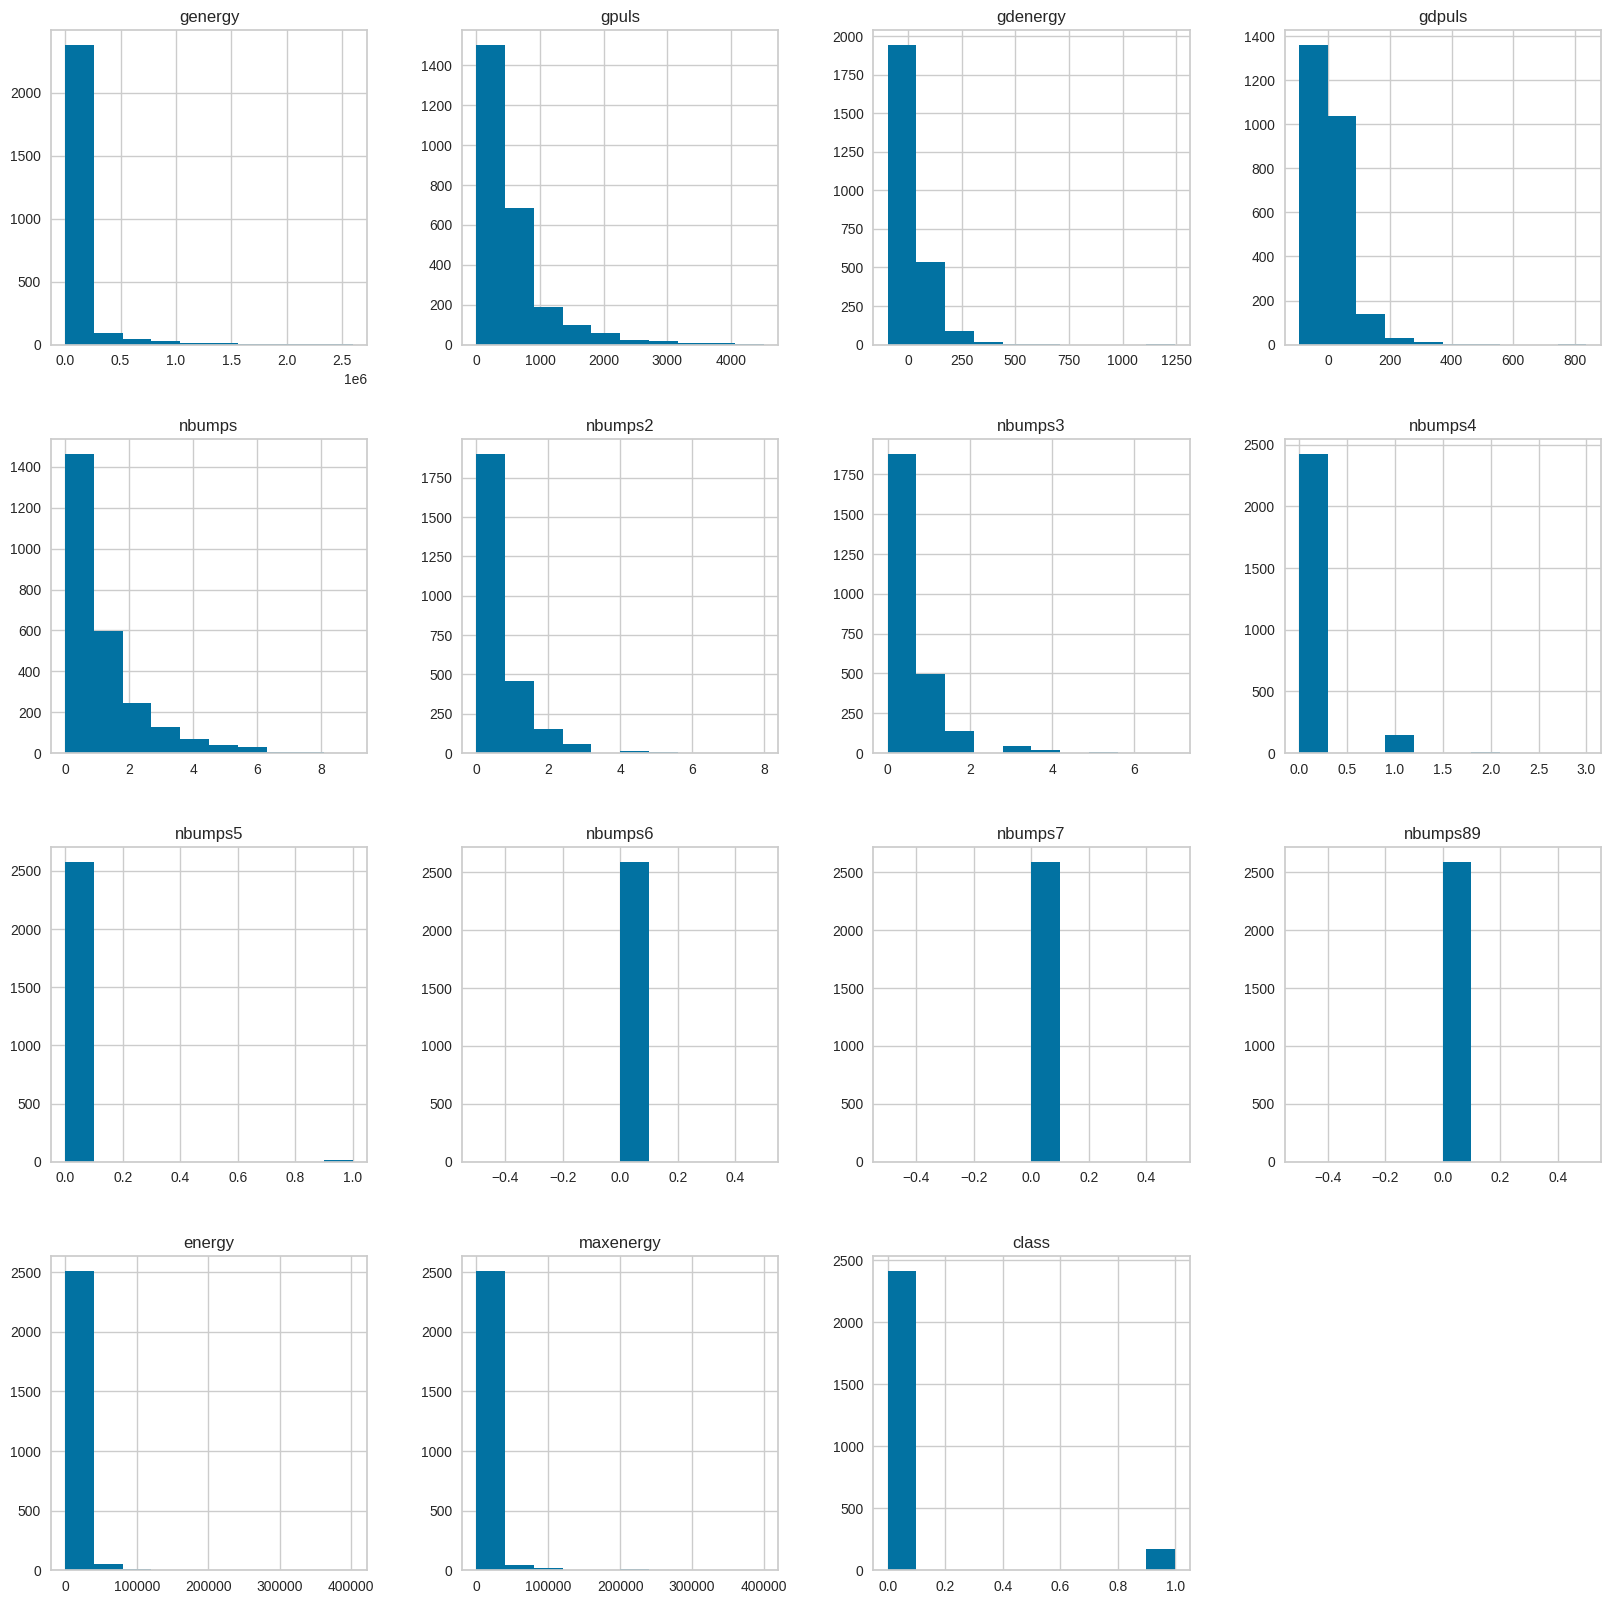

In [5]:
# Cómputo de la frecuencia de valores por variable, en forma de histograma
seismic.loc[:,:].hist(figsize=(20,20));

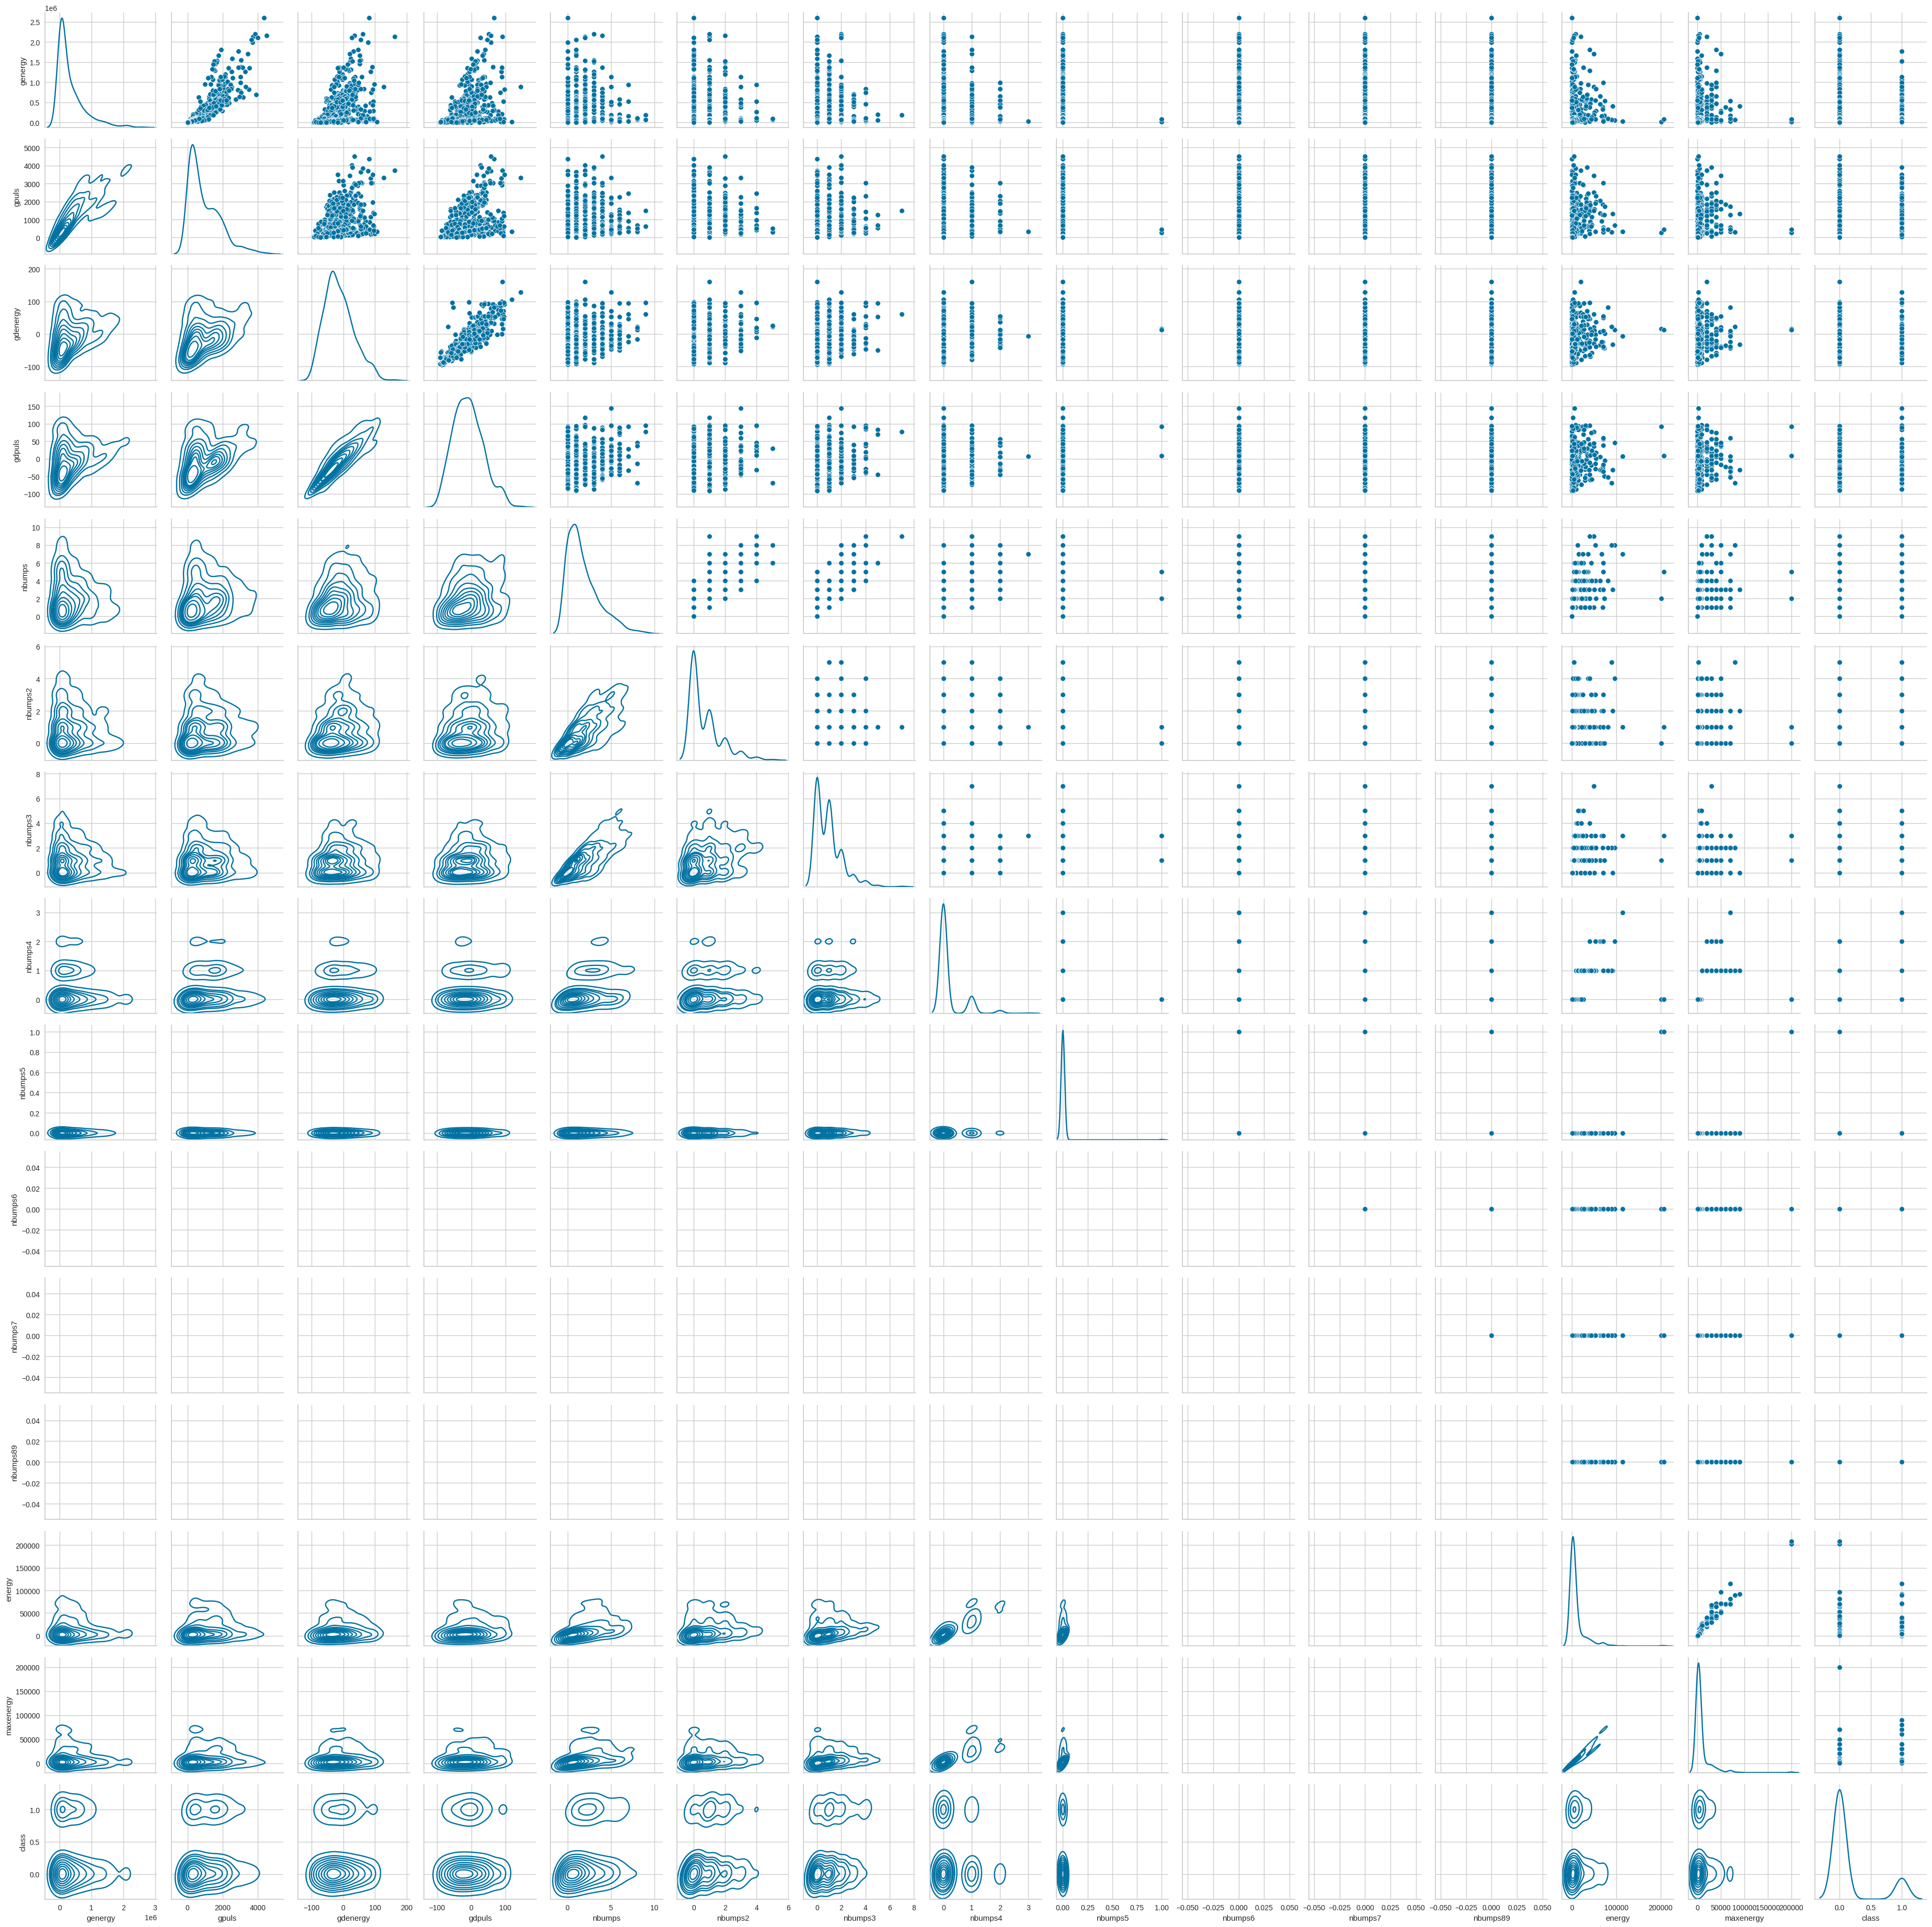

In [6]:
# Visualización de las relaciones de las variables con la variable objetivo
g = sns.PairGrid(seismic[:500], diag_sharey=False)    # Reducimos el número de muestras para facilitar el cómputo
g.map_upper(sns.scatterplot);
g.map_lower(sns.kdeplot);
g.map_diag(sns.kdeplot);

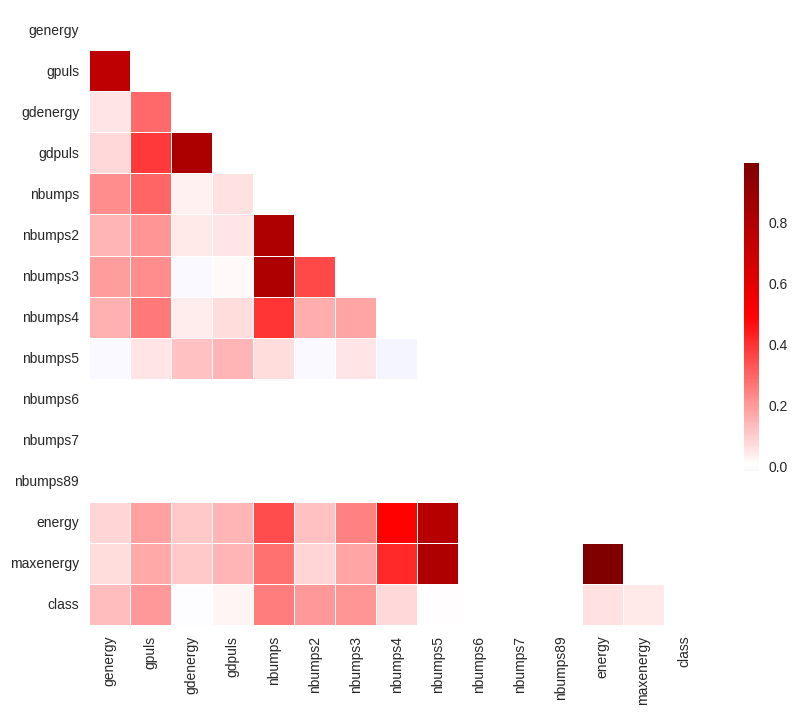

In [7]:
# Matriz de correlación entre la variable objetivo y el resto de variables
corr = seismic.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Descripción de los datos

El objetivo es predecir si la siguiente estimación tendrá valor class == 0 o class == 1 (no peligro / peligro).

Observamos que el dataset consta de 19 atributos y 2584 observaciones. Todos los atributos son numéricos menos seismic, seismoacustic y shift, que son categóricos. La variable objetivo es class, que es un atributo booleano que determina si existe peligro (==1) o no (==0).

Observamos que, a priori, ninguno de ellos consta de una distribución normal. Las variables categóricas (seismic, seismoacustic y shift) se corresponden con la peligrosidad de la actividad y el tipo de actividad (shift/coal-getting). Las variables numéricas se refieren a las mediciones registradas de energía, números de baches sísmicos registrados en rangos de energía, estadísticas de energía promedio y máximos de energía y, finalmente, resultado de peligrosidad / no peligrosidad.

Observamos también que los valores de los atributos no se reparten de forma homogenea, sino que se concentran en valores determinados, por eso encontramos picos tan altos en los histogramas. 

En cuanto a la correlación de las variables, encontramos que la variable objetivo "class" no tiene una correlación buena con ninguna de las demás variables. Los valores de correlación más cercanos se encuentran entre el 0.2 y 0.3. Por otra parte, sí que observamos buenas correlaciones entre otras variables, siendo la correlación más fuerte entre maxenergy y energy, con un 1 de correlación; rbumps3 con rbumps, con un valor aproximado entre 0.8 y 0.9; y rbumps2 y rbumps, con un valor aproximado de 0.8.

### Resolución mediante regresión/clasificación: Estudio preliminar 

A continuación, queremos ver si el problema se podría resolver mediante una regresión lineal o una clasificación.

Para ello, separamos el conjunto de training y de test en proporción 70%/30%, conjuntamente con un preproceso de los atributos categóricos a variables "dummy", que nos ayudarán a facilitar la regresión lineal.

In [8]:
#X = seismic[['seismic','seismoacoustic','shift','genergy','gpuls','gdenergy','gdpuls','ghazard','nbumps','nbumps2','nbumps3','nbumps4','nbumps5','nbumps6','nbumps7','nbumps89','energy','maxenergy']]
X = seismic.drop(columns=['class'])
Y = seismic[['class']]

X = pd.get_dummies(data=X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Instanciamos el modelo LinearRegression 
lr = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr.fit(X_train,y_train);

# Predecimos con el método predict 
y_pred = lr.predict(X_train);

In [9]:
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  class   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     12.91
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           7.56e-35
Time:                        17:19:37   Log-Likelihood:                -7.2840
No. Observations:                1808   AIC:                             50.57
Df Residuals:                    1790   BIC:                             149.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0212      0.012     -1.843      0.065      -0.044       0.001
genergy          -8.896e-08   4.23e-08     -2.102      0.036   -1.72e-07   -5.97e-09
gpuls                0.0001   2.08e-05      5.601      0.000    7.58e-05       0.000
gdenergy         -7.509e-05      0.000     -0.610      0.542      -0.000       0.000
gdpuls              -0.0002      0.000     -1.275      0.202      -0.001       0.000
nbumps               0.9982      0.244      4.084      0.000       0.519       1.478
nbumps2             -0.9585      0.245     -3.919      0.000      -1.438      -0.479
nbumps3             -0.9536      0.245     -3.899      0.000      -1.433      -0.474
nbumps4             -0.9568      0.249     -3.849      0.000      -1.444      -0.469
nbumps5             -0.5759      0.325     -1.775      0.076      -1.212       0.061
nbumps6          -7.147e-16   1.89e-16     -3.774      0.000   -1.09e-15   -3.43e-16
nbumps7          -5.077e-15   1.52e-15     -3.341      0.001   -8.06e-15    -2.1e-15
nbumps89          9.443e-17   3.28e-17      2.876      0.004       3e-17    1.59e-16
energy            1.044e-06   3.84e-06      0.272      0.786   -6.49e-06    8.58e-06
maxenergy        -2.799e-06   3.71e-06     -0.755      0.450   -1.01e-05    4.47e-06
seismic_b            0.0150      0.013      1.115      0.265      -0.011       0.041
seismoacoustic_b     0.0052      0.013      0.411      0.681      -0.020       0.030
seismoacoustic_c     0.0248      0.058      0.428      0.668      -0.089       0.139
shift_W              0.0042      0.014      0.294      0.769      -0.024       0.032
ghazard_b           -0.0118      0.023     -0.512      0.609      -0.057       0.033
ghazard_c           -0.0987      0.074     -1.334      0.182      -0.244       0.046
==============================================================================
Omnibus:                     1073.479   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7223.820
Skew:                           2.863   Prob(JB):                         0.00
Kurtosis:                      10.944   Cond. No.                     9.52e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Conclusiones del estudio preliminar

Observamos que la predicción con LinearRegression no es buena para este dataset concreto (R² muy bajo) y por ello necesitaremos de otros métodos de predicción.

### Preproceso de los datos

Antes de entrenar los modelos, queremos ver que los datos son completos, su dimensionalidad es adecuada, los datos están bien codificados, etc.

Empezamos de cero, descargando el dataset de nuevo y separando los datos:

In [10]:
# Carga de datos
seismic = pd.read_csv("./seismic-bumps.csv", header=0, delimiter = ',')

X = seismic.drop(columns=['class'])
Y = seismic[['class']]

##### Detección de valores nulos

In [11]:
X.isna().sum()

seismic           0
seismoacoustic    0
shift             0
genergy           0
gpuls             0
gdenergy          0
gdpuls            0
ghazard           0
nbumps            0
nbumps2           0
nbumps3           0
nbumps4           0
nbumps5           0
nbumps6           0
nbumps7           0
nbumps89          0
energy            0
maxenergy         0
dtype: int64

In [12]:
Y.isna().sum()

class    0
dtype: int64

Vemos que, efectivamente, el dataset no contiene valores nulos.

##### Valores anómalos (outliers)

Usamos el histograma de valores para ver si existen valores anómalos.

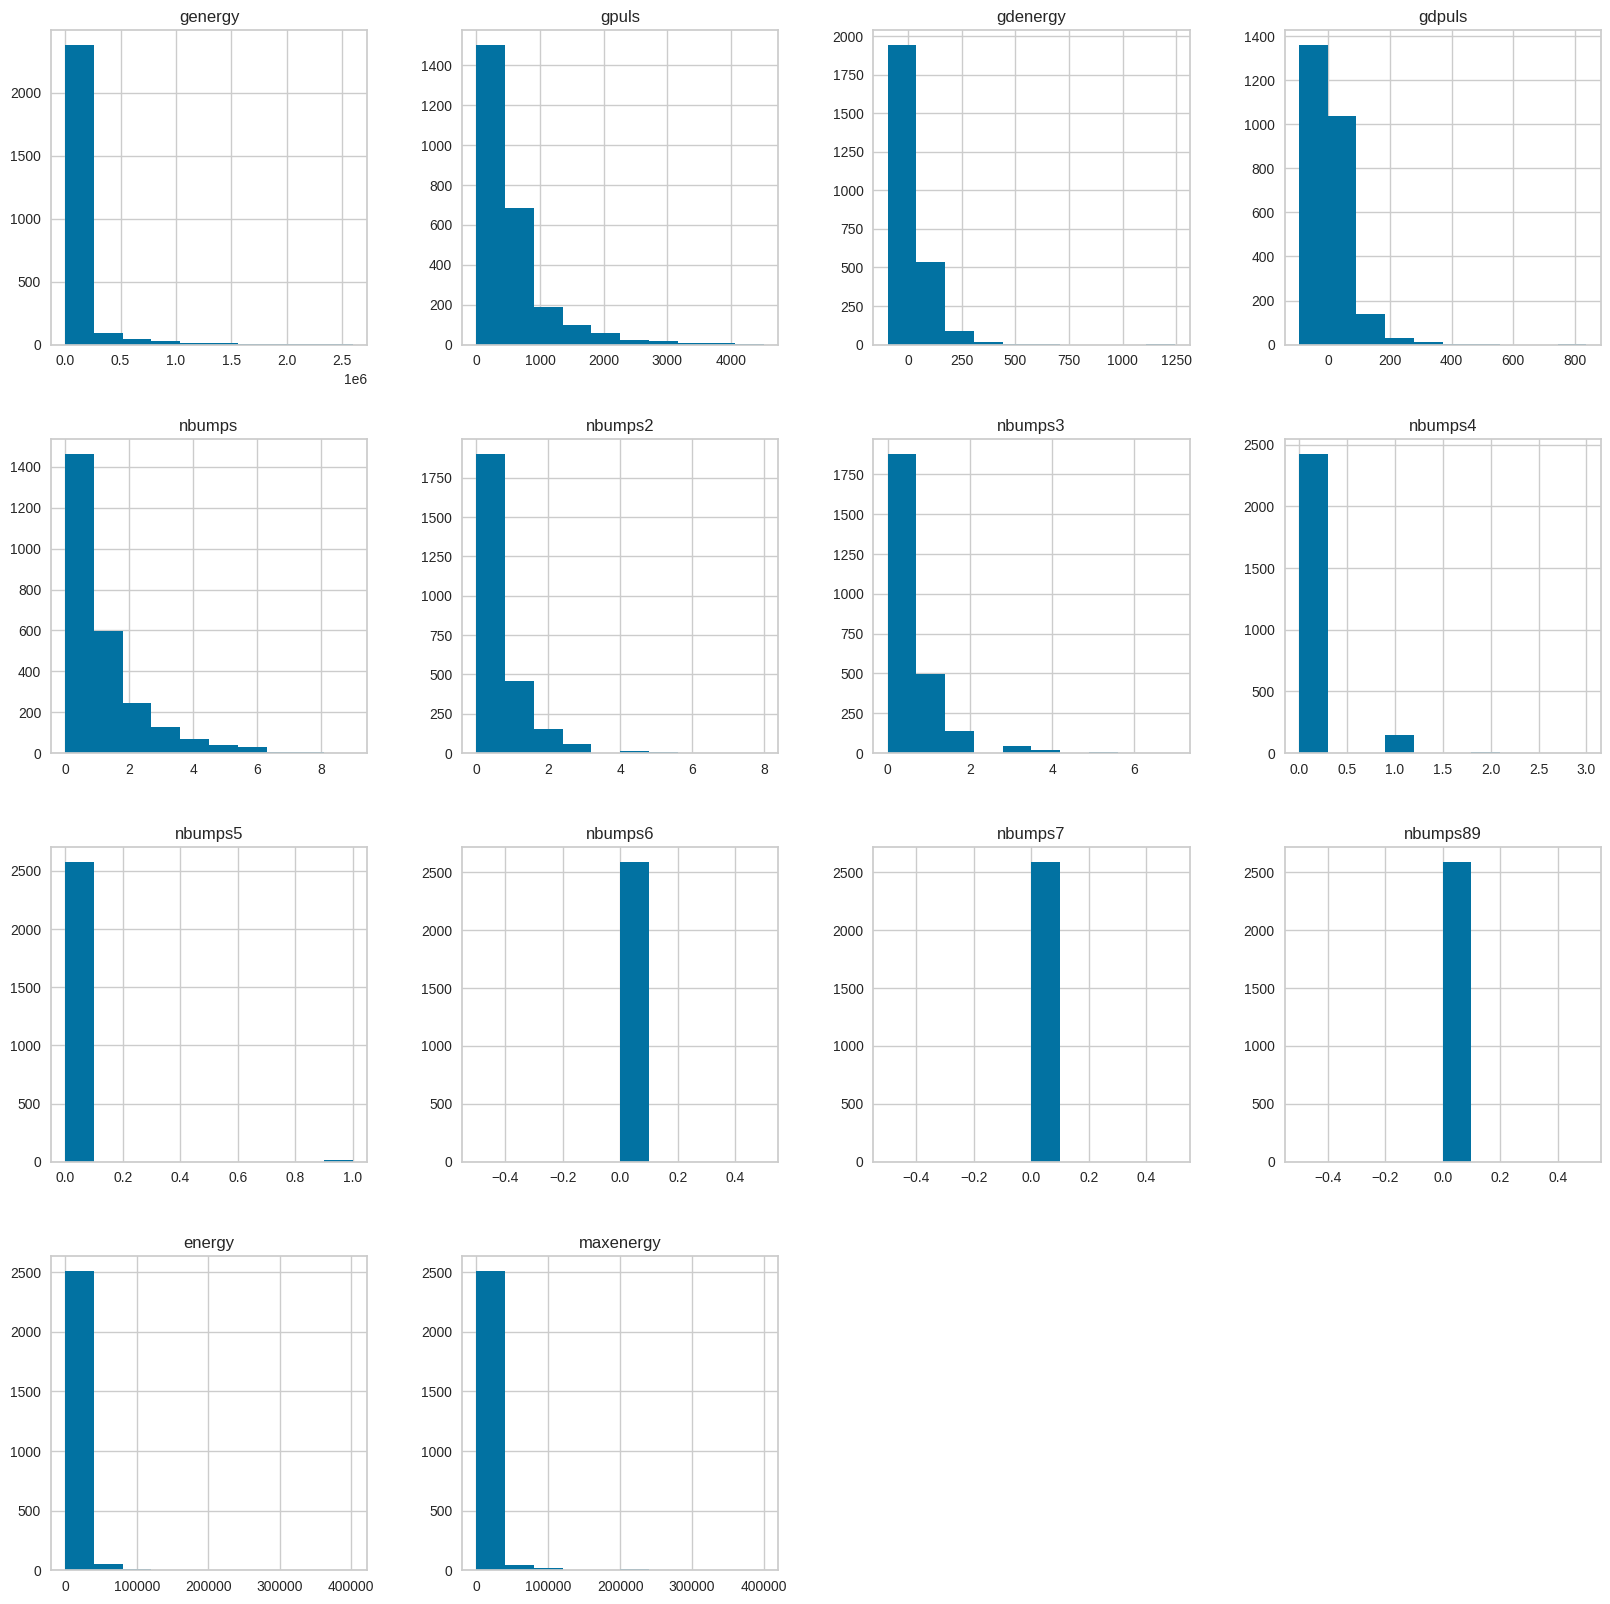

In [13]:
X.loc[:,:].hist(figsize=(20,20));

Observamos en el histograma que los valores anómalos, como en la gráfica de maxenergy o energy, observamos valores que se alejan de la media, pero eso es debido a existen eventos de una carga energética mayor que ocurren con una frecuencia mucho menor que otras actividades de menor carga energética, por lo que eliminar estos valores sería impropio, ya que lo que queremos predecir son los eventos peligrosos, normalmente de mayor carga energética.

##### Valores incoherentes/incorrectos

Usando el histograma anterior, también se pueden ver los valores incoherentes o incorrectos. A primera vista, no parece que existan valores incorrectos.

##### Codificación de variables no continuas o no ordenadas

In [14]:
# Transformamos las variables categóricas en variables dummies usando get_dummies()
X = pd.get_dummies(data=X, drop_first=True)

##### Posible eliminación de variables irrelevantes o redundantes

Vemos que id no proporciona ningún tipo de información relevante, por lo que lo vamos a eliminar.

In [15]:
# Eliminar variables que no son de utilidad para el problema
# seismic = seismic.drop(columns=['id'])

##### Creación de nuevas variables que puedan ser útiles

A priori, no sentimos la necesidad de crear nuevas variables para este problema. Creemos que el dataset ya es lo suficientemente descriptivo para proceder al entrenamiento y las predicciones.

##### Normalización de la variables

Normalizaremos las variables. Para ello, utilizamos estandarización:

AL FINAL NO LO HACEMOS, ESTO DA PROBLEMAS PARA LA REGRESIÓN LOGÍSTICA

In [16]:
X_std = X.copy()
Y_std = Y.copy()

In [17]:
X_std.describe().T

,count,mean,std,min,25%,50%,75%,max
genergy,2584.0,90242.523,229200.509,100.0,11660.0,25485.0,52832.50,2.596e+06
gpuls,2584.0,538.579,562.653,2.0,190.0,379.0,669.00,4.518e+03
gdenergy,2584.0,12.376,80.319,-96.0,-37.0,-6.0,38.00,1.245e+03
gdpuls,2584.0,4.509,63.167,-96.0,-36.0,-6.0,30.25,8.380e+02
nbumps,2584.0,0.860,1.365,0.0,0.0,0.0,1.00,9.000e+00
nbumps2,2584.0,0.394,0.784,0.0,0.0,0.0,1.00,8.000e+00
nbumps3,2584.0,0.393,0.770,0.0,0.0,0.0,1.00,7.000e+00
nbumps4,2584.0,0.068,0.279,0.0,0.0,0.0,0.00,3.000e+00
nbumps5,2584.0,0.005,0.068,0.0,0.0,0.0,0.00,1.000e+00
nbumps6,2584.0,0.000,0.000,0.0,0.0,0.0,0.00,0.000e+00


In [18]:
Y_std.describe().T

,count,mean,std,min,25%,50%,75%,max
class,2584.0,0.066,0.248,0.0,0.0,0.0,0.0,1.0


##### Transformación de las variables

A priori, no encontramos la necesidad de transformar ninguna variable. Puede ser que durante la experiencia del entrenamiento de modelos, veamos problemas y tengamos que volver al preproceso de datos para eliminar/añadir/transformar variables.

### Selección de modelos lineales/cuadráticos y estimación de rendimiento

Dado que el dataset especifica que el tipo de problema es de clasificación, tomaremos los siguientes 3 métodos y probaremos cuál de los 3 funciona mejor: regresión logística, Naive Bayes y k-vecinos más cercanos.

##### Primeramente, separamos los conjuntos de training y de test para el futuro entrenamiento de los modelos:

In [19]:
# Separación en conjuntos de test y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_std, Y_std, test_size=0.3, random_state=0)

#### Regresión logística

In [20]:
# Regresión logística
lr = LogisticRegression(max_iter=10000)
print(np.mean(cross_val_score(lr,X_train,y_train,cv=10, error_score='raise')))

0.8982504604051564


Vemos que los resultados de la cross-validated score son prometedores. Vamos a entrenar un modelo usando este método y veamos su acierto real.

In [21]:
lr_model = lr.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.9097938144329897

In [22]:
print(classification_report(lr_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       745
           1       0.02      0.03      0.03        31

    accuracy                           0.91       776
   macro avg       0.49      0.49      0.49       776
weighted avg       0.92      0.91      0.92       776



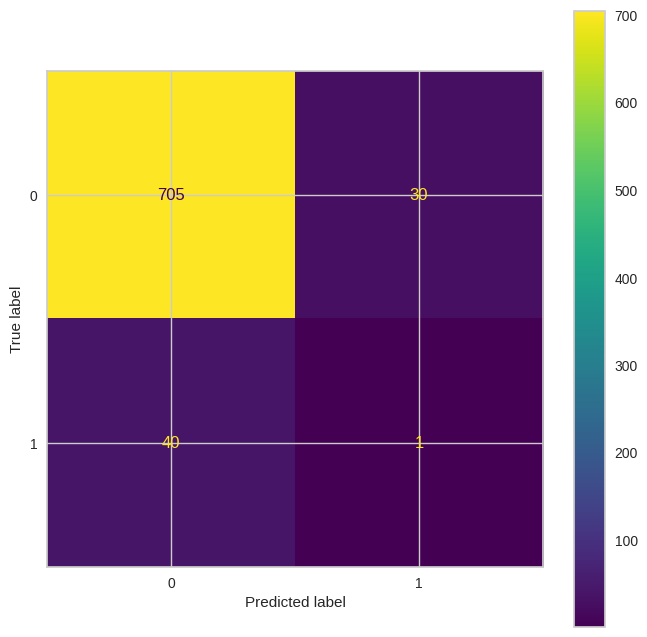

In [23]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, ax=plt.subplot());

#### Naive Bayes (Gaussian)

In [24]:
gnb = GaussianNB()
print(np.mean(cross_val_score(gnb,X_train,y_train,cv=10)))

0.8993278084714549


Observamos que es ligeramente inferior a regresión logística, pero veamos los resultados tras la predicción de valores.

In [25]:
gnb_model = gnb.fit(X_train, y_train)
gnb_model.score(X_test, y_test)

0.904639175257732

In [26]:
print(classification_report(gnb_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       733
           1       0.12      0.12      0.12        43

    accuracy                           0.90       776
   macro avg       0.54      0.53      0.53       776
weighted avg       0.90      0.90      0.90       776



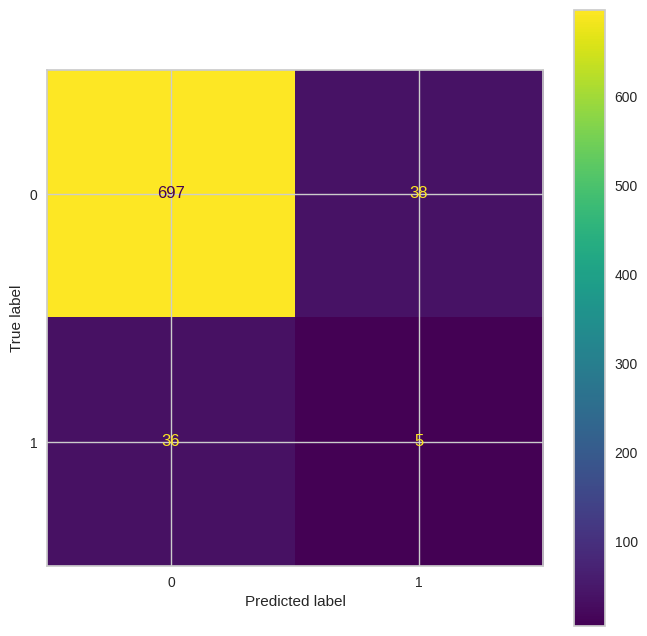

In [27]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test, y_test, ax=plt.subplot());

##### K-nearest neighbours

Para usar KNN debemos tener los datos estandarizados, por lo que usamos MinMax scaler.

In [28]:
# Normalización de los datos
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [60]:
knn =  KNeighborsClassifier()
print(np.mean(cross_val_score(knn,X_train_s,y_train,cv=10)))

0.9280969920196439


Vemos que la cross-validated score ofrece resultados teóricos prácticamente idénticos a regresión logística. Veamos los resultados prácticos:

In [30]:
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 30, 50], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

results = (0, None, 0) #Punctuation, Model, cv

for cv in range(2,10):
    knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
    knn_gs.fit(X_train_s, y_train["class"]);
    score = pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').loc[0, 'mean_test_score']

    if results[0] < score:
        results = (score, knn_gs, cv)
    
knn_gs = results[1]    
print("Para KNN, el mejor valor para cv dentro del experimento es:", results[2], "con puntuación de:", results[0])

Para KNN, el mejor valor para cv dentro del experimento es: 6 con puntuación de: 0.889940081993062


In [31]:
cv=5
niter = 15

In [32]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
103,"{'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1
199,"{'leaf_size': 30, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1
7,"{'leaf_size': 1, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1
151,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1
55,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1


In [33]:
cls = [str(v) for v in sorted(Y['class'].unique())]

print(classification_report(knn_gs.predict(X_test_s), y_test,target_names=cls))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       768
           1       0.00      0.00      0.00         8

    accuracy                           0.94       776
   macro avg       0.49      0.47      0.48       776
weighted avg       0.98      0.94      0.96       776



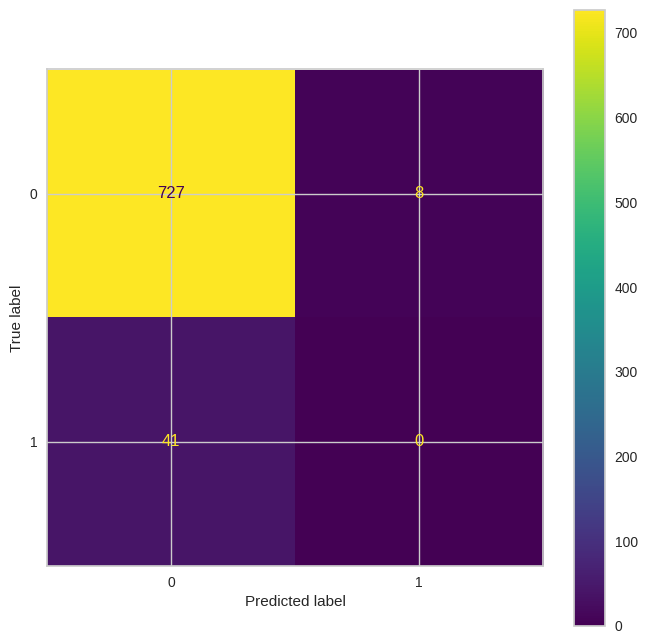

In [65]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s,y_test, display_labels=cls, ax=plt.subplot());

#### ROC curve

Después de entrenar los tres modelos, podemos observar la curva ROC de los tres modelos en conjunto, y valorar cuál de los tres ofrece mejores resultados:

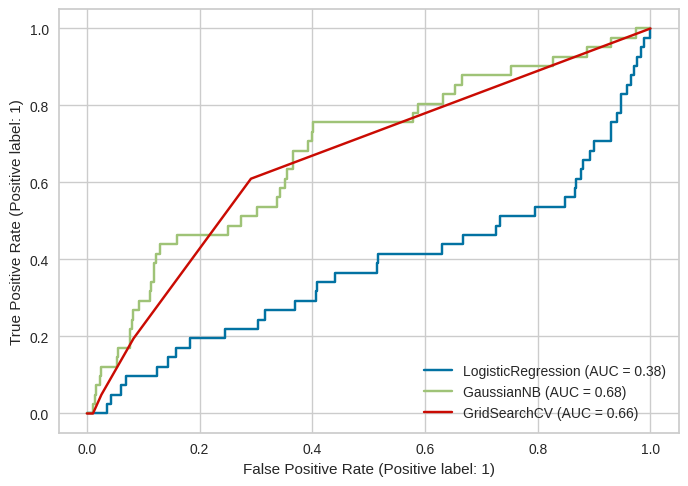

In [34]:
RocCurveDisplay.from_estimator(lr_model, X_test,y_test, pos_label=1, ax=plt.subplot());
RocCurveDisplay.from_estimator(gnb_model, X_test,y_test, pos_label=1, ax=plt.subplot());
RocCurveDisplay.from_estimator(knn_gs, X_test_s,y_test, pos_label=1, ax=plt.subplot());
plt.show()

Tenemos que apreciar que KNN utiliza datos normalizados, de manera que el gráfico no muestra una comparativa muy precisa respecto al resto de gráficas. A partir de esta, obtenemos los siguientes resultados:

Observamos que KNN ofrece la mayor relación true positive/false positive en la mayor parte del rango comprendido por la gráfica. Si queremos coger un valor que ofrezca una buena relación, podemos coger el mejor modelo para x=0.4, por ejemplo. Observamos que el mejor resultado lo ofrece KNN.

Regresión linear ofrece ligeramente mejores resultados prácticos que KNN, pero obtiene mayor tasa de falsos positivos en relación a los auténticos positivos, por lo que nos quedaremos con KNN.

Naive Bayes no lo consideramos porque ofrece menor score que Linear regression y KNN, así como mayor tasa de falsos positivos.

### Selección de modelos no lineales y estimación de rendimiento

En el estudio de los modelos no lineales, hemos seleccionado los siguientes: MLP, Random Forest y Gradient Boosting. Veamos su entrenamiento y selección de los mejores hiperparámetros:

##### MLP (Multi-Layer Perceptron)

Para utilizar MLP debemos normalizar los datos. Como hemos visto en laboratorio, la estandarización proporciona una mayor convergencia, por lo que el proceso es más rápido.

In [35]:
# Estandarización de los datos de entrenamiento y testing
sdscaler = StandardScaler()

X_train_sd = sdscaler.fit_transform(X_train)
X_test_sd = sdscaler.transform(X_test)

In [36]:
# Declaración del clasificador MLP con early_stopping para menor sobre ajuste.
mlp = MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=15, random_state=0)
print(np.mean(cross_val_score(mlp,X_train_sd,y_train,cv=10)))

0.9258717004297115


Vemos que la cross-validation score es similar a KNN. Veamos el acierto práctico cuando se entrena el modelo y se predicen los valores sobre X_test.

In [37]:
param = {'hidden_layer_sizes':[10, 50, 100, 200, 500, 1000], 
         'activation':['relu', 'logistic', 'identity'], 
         'learning_rate_init': [0.00001, 0.0001, 0.001, 0.01, 0.1]  }

results = (0,None,0) # Score, Model, cv

for cv in range(2,10):
    mlp =  MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=20,learning_rate='adaptive',random_state=0)
    mlp_gs =  GridSearchCV(mlp,param,cv=cv, n_jobs=-1, refit=True)
    mlp_gs.fit(X_train_sd, y_train["class"]);
    
    score = pd.DataFrame(mlp_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='mean_test_score').loc[0,"mean_test_score"]
    if results[0] < score:
        results = (score,mlp_gs,cv)
        
mlp_gs = results[1]
print("Para MLP, el mejor valor para cv dentro del experimento es:", results[2], "con puntuación de:", results[0])

Para MLP, el mejor valor para cv dentro del experimento es: 6 con puntuación de: 0.396023556504074


In [38]:
show_html(pd.DataFrame(mlp_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
33,"{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01}",0.929,1
49,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.1}",0.929,2
18,"{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01}",0.929,3
17,"{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.001}",0.929,3
27,"{'activation': 'relu', 'hidden_layer_sizes': 1000, 'learning_rate_init': 0.001}",0.929,3


Como en los modelos previos, el resultado práctico es peor que el teórico. Observamos que los mejores hiperparámetros para este entrenamiento son: Activación ReLU, 100 de tamaño de capas ocultas y tasa inicial de aprendizaje a 0.001. 

In [39]:
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300], 
'activation':['relu', 'identity', 'logistic'], 
'alpha':[0.0001, 0.001, 0.01],
'momentum': [0.95, 0.90, 0.85, 0.8], 
'learning_rate_init': [0.001, 0.01, 0.1],
'n_iter_no_change':[10, 20, 40, 50], 
'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs =  BayesSearchCV(mlp,param,
                        n_iter=niter, 
                        cv=cv, n_jobs=-1, 
                        refit=True,random_state=0)
mlp_bs.fit(X_train_sd, y_train["class"]);

In [40]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
0,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.95, 'n_iter_no_change': 10}",0.929,1
2,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 40}",0.929,1
9,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 50, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 40}",0.929,1
12,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 40}",0.929,1
13,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 20}",0.929,1


Probamos con Bayes Search pero no obtenemos resultados mejores. Observamos que los mejores hiperparámetros nos proprocionan una puntuación con una cota superior de 0.93, que en ningún caso se supera, ya sea usando Bayes Search o no. Dado que no podemos mejorarlo, nos quedaremos con el resultado del modelo más simple (el que no utiliza Bayes) para compararlo con el resto de modelos obtenidos.

Al final del entrenamiento de los 3 modelos elegidos en la sección de modelos no lineales, veremos la curva ROC y compararemos su comportamiento.

In [41]:
print(classification_report(mlp_bs.predict(X_test), y_test,target_names=cls))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       776
           1       0.00      0.00      0.00         0

    accuracy                           0.95       776
   macro avg       0.50      0.47      0.49       776
weighted avg       1.00      0.95      0.97       776



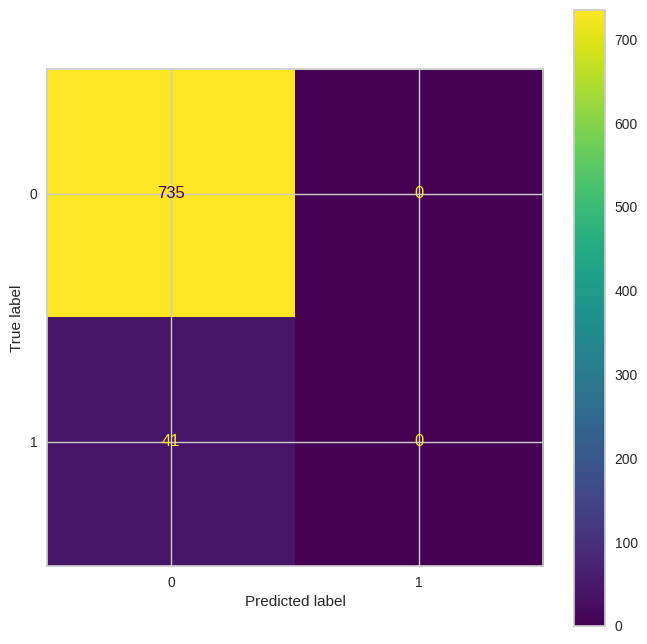

In [42]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test,y_test, ax=plt.subplot())

##### Random Forest

In [43]:
rf =  RandomForestClassifier(random_state=0)
print(np.mean(cross_val_score(rf,X_train_sd,y_train,cv=10)))

0.9275475751995088


In [44]:
iter=40
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf_bs =  BayesSearchCV(rf,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train, y_train["class"]);

In [45]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
7,"{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}",0.930,1
35,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 40}",0.930,2
38,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50}",0.930,3
12,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 5}",0.929,4
13,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}",0.929,5


In [46]:
print(classification_report(rf_bs.predict(X_test), y_test,target_names=cls))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       768
           1       0.02      0.12      0.04         8

    accuracy                           0.94       776
   macro avg       0.51      0.54      0.50       776
weighted avg       0.98      0.94      0.96       776



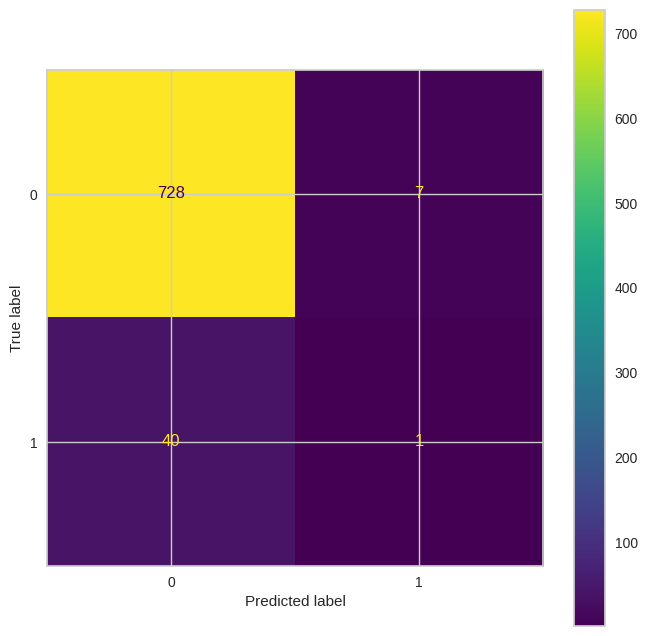

In [47]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rf_bs, X_test,y_test, ax=plt.subplot())

##### Gradient Boosting

In [48]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss', 'exponential'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train, y_train["class"]);

In [49]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
20,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}",0.930,1
30,"{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 25}",0.929,2
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.929,2
36,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 100}",0.929,2
27,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 10}",0.929,2


In [50]:
print(classification_report(gb_bs.predict(X_test), y_test,target_names=cls))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       772
           1       0.02      0.25      0.04         4

    accuracy                           0.94       776
   macro avg       0.51      0.60      0.51       776
weighted avg       0.99      0.94      0.97       776



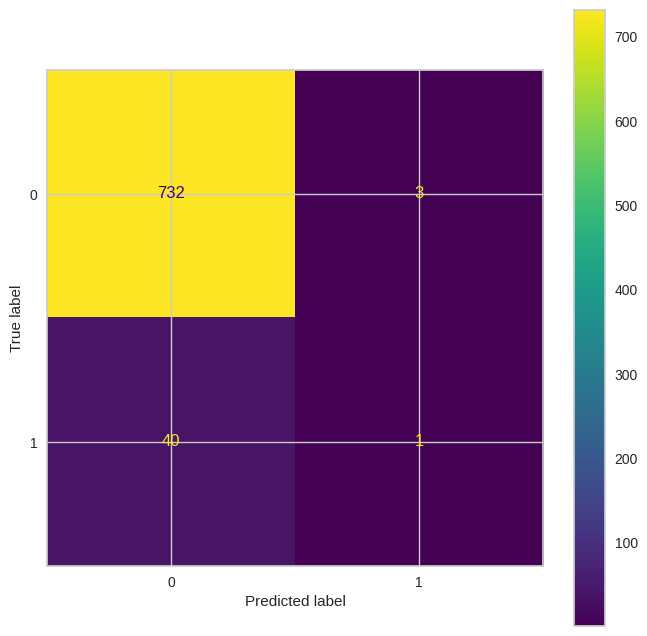

In [51]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gb_bs, X_test,y_test, ax=plt.subplot())

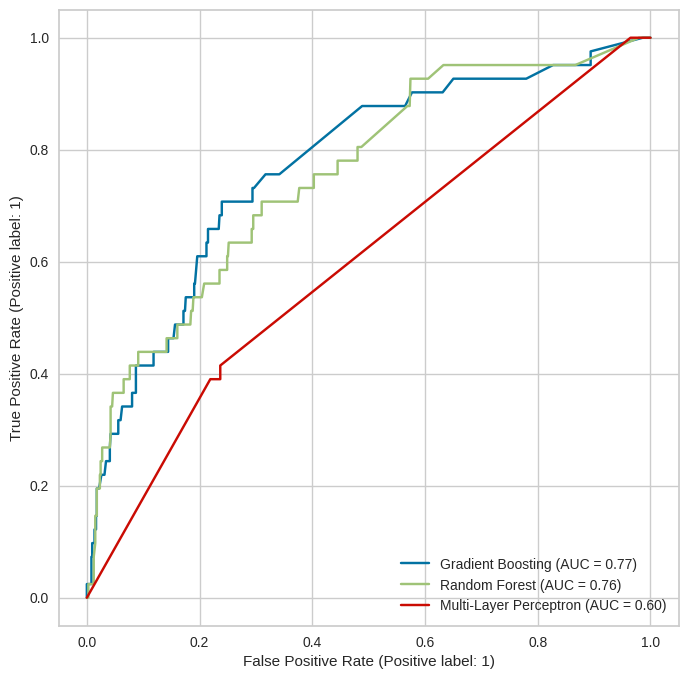

In [52]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(gb_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='Gradient Boosting');
RocCurveDisplay.from_estimator(rf_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='Random Forest');
RocCurveDisplay.from_estimator(mlp_gs, X_test,y_test, pos_label=1, ax=plt.subplot(), name="Multi-Layer Perceptron");

Como MLP necesita que la entrada esté normalizada (estandarización) la curva ROC no aparece de manera adecuada en comparación al resto de valores, para Gradient Boosting y Random Forest. 

Si analizamos las gráficas comparables, vemos que la línea de Gradient Boosting casi siempre toma valores más altos en el eje vertical (True positives) que la gráfica de Random Forest, por lo que podemos pensar que Gradient Boosting ofrece mejores resultados (mayor tasa de auténticos positivos en relación a los falsos positivos).

Como los resultados de MLP en la práctica son prácticamente iguales a GB y RF, cogeremos como mejor modelo Gradient Boosting, en el apartado de modelos no lineales.

### Elección final del modelo, justificación y características

Del apartado de modelos lineales hemos escogido K Nearest Neighbours, y de los modelos no lineales hemos escogido Gradient Boosting. Veamos las curvas ROC y los datos comparativos para decidirnos sobre el modelo final:

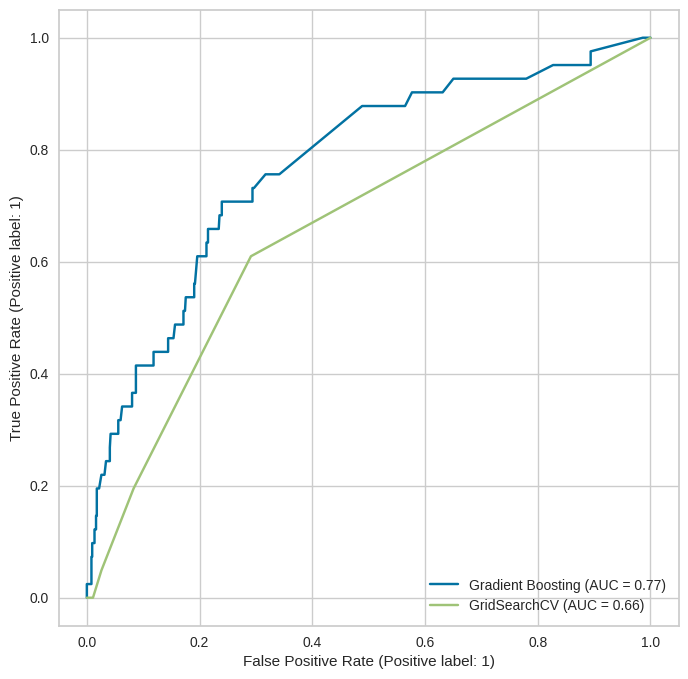

In [53]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(gb_bs, X_test,y_test, pos_label=1, ax=plt.subplot(), name='Gradient Boosting');
RocCurveDisplay.from_estimator(knn_gs, X_test_s,y_test, pos_label=1, ax=plt.subplot());

In [54]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
103,"{'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1
199,"{'leaf_size': 30, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1
7,"{'leaf_size': 1, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1
151,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1
55,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'uniform'}",0.931,1


In [55]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
20,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}",0.930,1
30,"{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 25}",0.929,2
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.929,2
36,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 100}",0.929,2
27,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 10}",0.929,2


In [56]:
print(classification_report(knn_gs.predict(X_test_s), y_test,target_names=cls))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       768
           1       0.00      0.00      0.00         8

    accuracy                           0.94       776
   macro avg       0.49      0.47      0.48       776
weighted avg       0.98      0.94      0.96       776



In [57]:
print(classification_report(gb_bs.predict(X_test), y_test,target_names=cls))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       772
           1       0.02      0.25      0.04         4

    accuracy                           0.94       776
   macro avg       0.51      0.60      0.51       776
weighted avg       0.99      0.94      0.97       776



A través de la curva ROC podemos observar que Gradient Boosting ofrece mejores resultados en todos los valores del eje horizontal, por lo que de momento consideramos Gradient Boosting como la mejor opción.

Si analizamos los valores de mean test score para ambos modelos, vemos que los valores son muy similares, superando KNN a Gradient Boosting por 0.003. La diferencia es mínima, por lo que realmente no podemos añadir diferencia a través de estos datos.

Finalmente, observamos que las puntuaciones tras las predicciones sobre el conjunto de test son muy similares también. Para KNN obtenemos unos valores de (0.98, 0.94, 0.96), mientras que para GB tenemos (1.00, 0.95, 0.97). Los valores para GB son ligeramente superiores a KNN, por lo que tomaremos como mejor resultado en este aspecto el modelo de GB.

Tras todos los análisis, vemos que GB es mejor que KNN para este dataset en concreto, con una mayor puntuación y menor tasa de falsos positivos por número de auténticos positivos.

### Referencias

Utilizamos citación en formato APA para esta práctica:

- UCI Machine Learning Repository: seismic-bumps Data Set. (s. f.). Recuperado 24 de octubre de 2022, de http://archive.ics.uci.edu/ml/datasets/seismic-bumps
- haloboy777. (n.d.). Haloboy777/arfftocsv: Arff to CSV converter (python). GitHub. Recuperado 27 de diciembre de 2022, de https://github.com/haloboy777/arfftocsv 